This is a neural network which classifies music genres based on spectograms. The tracks were originally collected from 30 second samples downloaded using the Spotify API. The spectograms are passed through 4 convolutional layers followed by a 2 layer GRU.

In [0]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import fastai
import torch
from fastai.vision import *
from sklearn import preprocessing
from google.colab import drive
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla P100-PCIE-16GB


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
spectogram_folder = "/content/drive/My Drive/preview_spectograms/"
spotify_data = pd.read_csv("/content/drive/My Drive/spotify_track_preview_data.csv")
del spotify_data['Unnamed: 0']
del spotify_data['playlist']
del spotify_data['preview_url']
del spotify_data['genre_long']
spotify_data.sample(5)

,track_id,track_name,track_artists,genre_short
4138,678jC81MyVTsvPTjvgMnRJ,Tracer,['Darmec'],techno
3065,6STqpEMvbgC1GXoipBn5KF,"Piano Sonata No. 5 in C Minor, Op. 10, No. 1: ...","['Ludwig van Beethoven', 'Steven Masi']",classical
14897,5YQHPDH1Z1ZDxrobBSCsJr,Let It Snow! Let It Snow! Let It Snow!,['Sufjan Stevens'],folk
29246,7Ahf1Gu3LQtGH90P6IaDrE,Silent Night,['Universe Mind'],classical
25427,1wtVsUNcIodD24ANmceWmY,The Great Gathering,['Battlelore'],folk


In [5]:
spotify_data['genre_short'].value_counts()

techno       9844
jazz         7212
classical    5947
folk         4405
metal        3497
r&b          3385
rap          1714
rock         1656
pop          1317
house         620
Name: genre_short, dtype: int64

In [6]:
spotify_data.rename(columns={'track_id':'image_path', 'genre_short':'label'}, inplace=True)
prefixes = spotify_data['label'].astype(str) + "/" + spotify_data['image_path'].astype(str).str[0] + "/"
spotify_data['image_path'] = prefixes + spotify_data['image_path'].astype(str) + '.png'
label_encoder = preprocessing.LabelEncoder()
spotify_data['label'] = label_encoder.fit_transform(spotify_data['label'].astype('str'))
spotify_data.sample(5)

,image_path,track_name,track_artists,label
2250,classical/3/33u02H1u34XeBqBsiP6c9T.png,"Waltzes, Op. 64: No. 1 in D-Flat Major, ""Minut...","['Frédéric Chopin', 'Vitaly Margulis']",0
38679,folk/7/7jUczfUWKAfcKSQP2N8ugb.png,Local Boys,"['Anirudh Ravichander', 'Dhanush', 'Velmurugan']",1
34405,techno/1/186AJdrAFz8PSbtqOMQmf1.png,Send a Prayer - Pt. 2,['Motor City Drum Ensemble'],9
30961,classical/5/5ljHA0RktQzKcuIEw6CH6l.png,Spinning,['Advaita'],0
34295,techno/6/6Vg2RcuZ6yvo3jCVeAJgZ4.png,Tania - Steve Lawler Remix,"['Harry Romero', 'Steve Lawler']",9


In [0]:
x_train, x_test = train_test_split(spotify_data, test_size=0.2, random_state=42)
y_test = x_test['label'].copy()

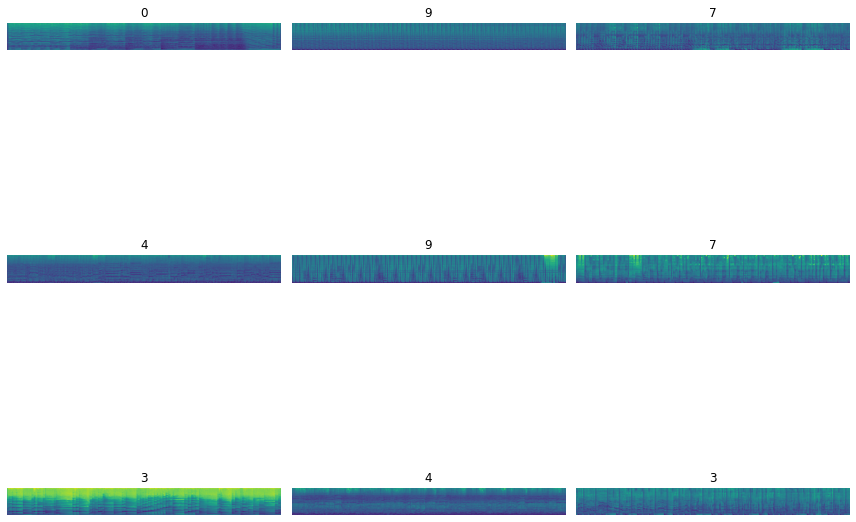

In [8]:
batch_size = 64
num_workers = 16
image_size = (128, 1292)

src = (ImageList.from_df(df=x_train, path=spectogram_folder, cols='image_path', convert_mode='L')
       .split_by_rand_pct(0.2, seed=42)
       .label_from_df(cols='label'))
data = (src.transform(size=image_size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=batch_size, num_workers=num_workers))
data.show_batch(rows=3, ds_type=DatasetType.Train)

In [0]:
class CRNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(CRNN, self).__init__()
        self.cnn = CNN(num_channels)
        self.rnn = RNN(num_channels, num_classes)

    def forward(self, input):
        # [batch, channel, decibels, time]
        cnn_output = self.cnn(input)
        rnn_input = cnn_output.squeeze().permute(0, 2, 1)
        # [batch, sequence, features]
        rnn_output = self.rnn(rnn_input)
        return F.log_softmax(rnn_output, dim=1)


class CNN(nn.Module):

    def __init__(self, num_channels):
        super(CNN, self).__init__()
        self.conv1 = self.make_conv_layer(1, num_channels, 2)
        self.conv2 = self.make_conv_layer(num_channels, num_channels, 2)
        self.conv3 = self.make_conv_layer(num_channels, num_channels, 2)
        self.conv4 = self.make_conv_layer(num_channels, num_channels, (4, 2))
        self.conv5 = self.make_conv_layer(num_channels, num_channels, (4, 4))
    
    def make_conv_layer(self, in_channels, out_channels, max_pool_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(),
            nn.MaxPool2d(max_pool_size))

    def forward(self, input):
        feature_map = self.conv1(input)
        feature_map = self.conv2(feature_map)
        feature_map = self.conv3(feature_map)
        feature_map = self.conv4(feature_map)
        return self.conv5(feature_map)


class RNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(RNN, self).__init__()
        self.gru = nn.GRU(num_channels, num_channels, num_layers=2, batch_first=True)
        self.linear = nn.Linear(20 * num_channels, num_classes)

    def forward(self, input):
        gru_output, _ = self.gru(input)
        linear_input = gru_output.contiguous().view(gru_output.size(0), -1)
        return self.linear(linear_input)

In [0]:
num_channels = 64
num_classes = len(spotify_data['label'].unique())

model = CRNN(num_channels, num_classes)
if torch.cuda.is_available():
    model = model.to(device)
learn = Learner(data, model, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.32E-03


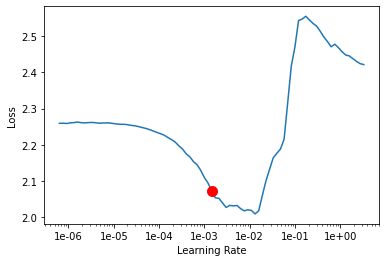

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
learn.recorder.min_grad_lr

0.001445439770745928

In [13]:
learn.fit_one_cycle(cyc_len=10, max_lr=learn.recorder.min_grad_lr, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.926248,1.666555,0.459511,18:02
1,0.873031,0.970931,0.685399,03:02
2,0.825836,0.834880,0.725335,03:02
3,0.739308,0.849319,0.717443,03:02
4,0.701674,0.855311,0.715075,03:02
5,0.628932,0.764941,0.759590,03:02
6,0.578367,0.693444,0.770008,03:02
7,0.506632,0.674917,0.780426,03:02
8,0.437387,0.643905,0.794791,03:02
9,0.412363,0.638783,0.793212,03:03


In [0]:
learn.save('crnn_genre_model')

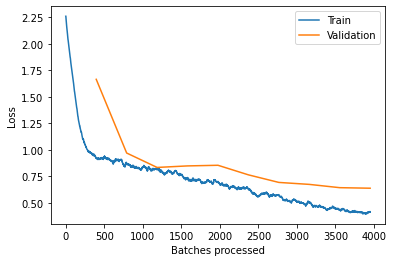

In [15]:
learn.recorder.plot_losses()

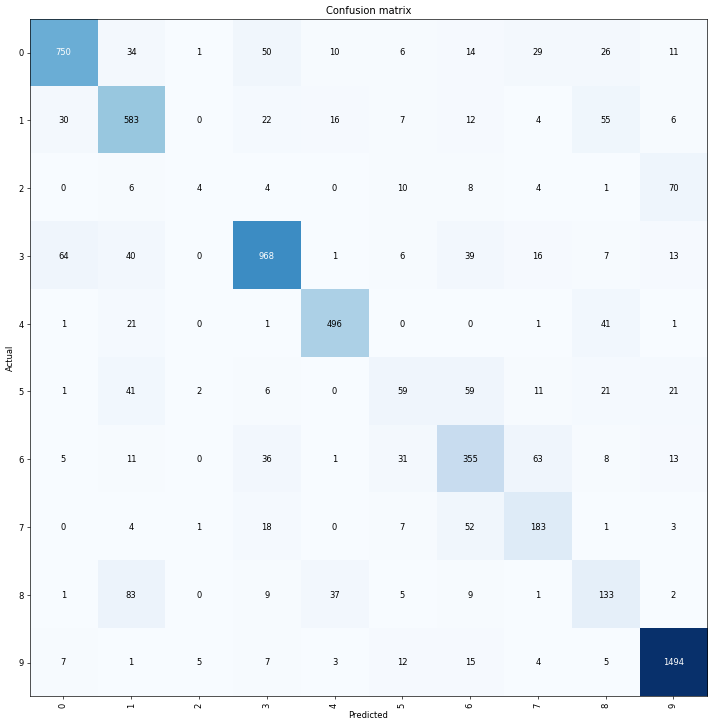

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [17]:
class_names = label_encoder.inverse_transform(spotify_data['label'].unique())
for confused in interp.most_confused(min_val=20):
    print("{0} was confused with {1} {2} times."
    .format(class_names[confused[0]], class_names[confused[1]], confused[2]))

rap was confused with jazz 83 times.
folk was confused with metal 70 times.
techno was confused with classical 64 times.
house was confused with rock 63 times.
r&b was confused with house 59 times.
jazz was confused with rap 55 times.
rock was confused with house 52 times.
classical was confused with techno 50 times.
pop was confused with rap 41 times.
r&b was confused with jazz 41 times.
techno was confused with jazz 40 times.
techno was confused with house 39 times.
rap was confused with pop 37 times.
house was confused with techno 36 times.
classical was confused with jazz 34 times.
house was confused with r&b 31 times.
jazz was confused with classical 30 times.
classical was confused with rock 29 times.
classical was confused with rap 26 times.
jazz was confused with techno 22 times.
pop was confused with jazz 21 times.
r&b was confused with rap 21 times.
r&b was confused with metal 21 times.


In [18]:
learn.data.add_test(ImageList.from_df(df=x_test, path=spectogram_folder, cols='image_path'))
probs, _ = learn.get_preds(ds_type=DatasetType.Test)

In [19]:
def calculate_accuracy(predictions, answers):
    score = 0
    for i in range(len(answers)):
        if answers[i] in predictions[i]:
            score += 1
    return score / len(answers)

print("Test set accuracy scores:\n")

#top1
pred_class = torch.argmax(probs, dim=1)
answers = y_test.tolist()
score = calculate_accuracy(pred_class, answers)
print("Top 1: {0:.2f}%".format(score * 100))

#top5
top_classes = np.argsort(probs, axis=1)[:,-5:]
score = calculate_accuracy(top_classes, answers)
print("Top 5: {0:.2f}%".format(score * 100))

Test set accuracy scores:

Top 1: 80.76%
Top 5: 98.30%
